In [3]:
using PyPlot
using Statistics # mean函数需要这个模块
#using Plots.Measures

# -------------------------------------------------------------------
# --- Part 1: 完美晶格的计算 (Calculation for Perfect Lattice) ---
# -------------------------------------------------------------------

# -- 计算设置 --
const N_q_points = 1000
const N_omega_points = 1000
const eta = 0.001

# 物理参数
const M = 1.0
const C = 1.0
const a = 1.0

println("Step 1: Pre-calculating properties of the PERFECT LATTICE...")

# --- 声子谱 ---
q_values = range(-π / a, π / a, length=N_q_points)
eigenvalues_w_sq = (4 * C / M) .* sin.(q_values .* a ./ 2).^2
frequencies = sqrt.(eigenvalues_w_sq)
max_freq = maximum(frequencies)
omega_range = range(0.01, 3, length=N_omega_points)

# --- 计算格林函数和谱函数 ---
# 利用广播机制创建 (N_q x N_omega) 的矩阵
denominators_grid = (omega_range' .+ 1im * eta ).^2 .- eigenvalues_w_sq 
G0_q_omega_grid = 1.0 ./ denominators_grid
A0_grid = -imag.(G0_q_omega_grid) ./ π

# 计算局域格林函数 G₀(i=j, ω)，通过对所有q求平均得到
# mean(..., dims=1) 会返回一个行矩阵，我们用vec()将其转换成向量
G0_onsite_all_omega = vec(mean(G0_q_omega_grid, dims=1))

println("Done.")


# -------------------------------------------------------------------
# --- Part 2: 缺陷晶格的计算 (Calculation for Defective Lattice) ---
# -------------------------------------------------------------------

# -- 缺陷参数 --
const m_imp = 0.5  # 杂质原子质量。可以尝试轻杂质(<1.0)或重杂质(>1.0)
const conc = 0.5 # 

println("Step 2: Calculating properties of the DEFECTIVE LATTICE using T-matrix...")

# 计算质量差
delta_m = m_imp - M

# 计算频率相关的缺陷势 V(ω)
v_defect_all_omega = -delta_m .* omega_range.^2

# T-矩阵近似 T(ω) = c * V(ω) / (1 - G₀_site * V(ω))
T_matrix_all_omega = conc .* v_defect_all_omega ./ (1.0 .- G0_onsite_all_omega .* v_defect_all_omega)

# 计算格林函数的改变量 ΔG(q, ω) = |G₀(q, ω)|² * T(ω)
# 为了广播T矩阵，我们需要将其从向量变为 (1 x N_omega) 的行矩阵
T_matrix_row = reshape(T_matrix_all_omega, 1, :)
delta_G_grid = abs.(G0_q_omega_grid).^2 .* T_matrix_row

# 缺陷晶格的全格林函数 G(q, ω) = G₀(q, ω) + ΔG(q, ω)
G_full_q_omega_grid = G0_q_omega_grid .+ delta_G_grid

# 缺陷晶格的谱函数 A(q, ω)
A_full_grid = -imag.(G_full_q_omega_grid) ./ π
sigma_real = real.(T_matrix_row)
sigma_imag = imag.(T_matrix_row)

# (可选) 计算谱函数的改变量
delta_A_grid = A_full_grid - A0_grid

println("Done.")




Step 1: Pre-calculating properties of the PERFECT LATTICE...
Done.
Step 2: Calculating properties of the DEFECTIVE LATTICE using T-matrix...
Done.


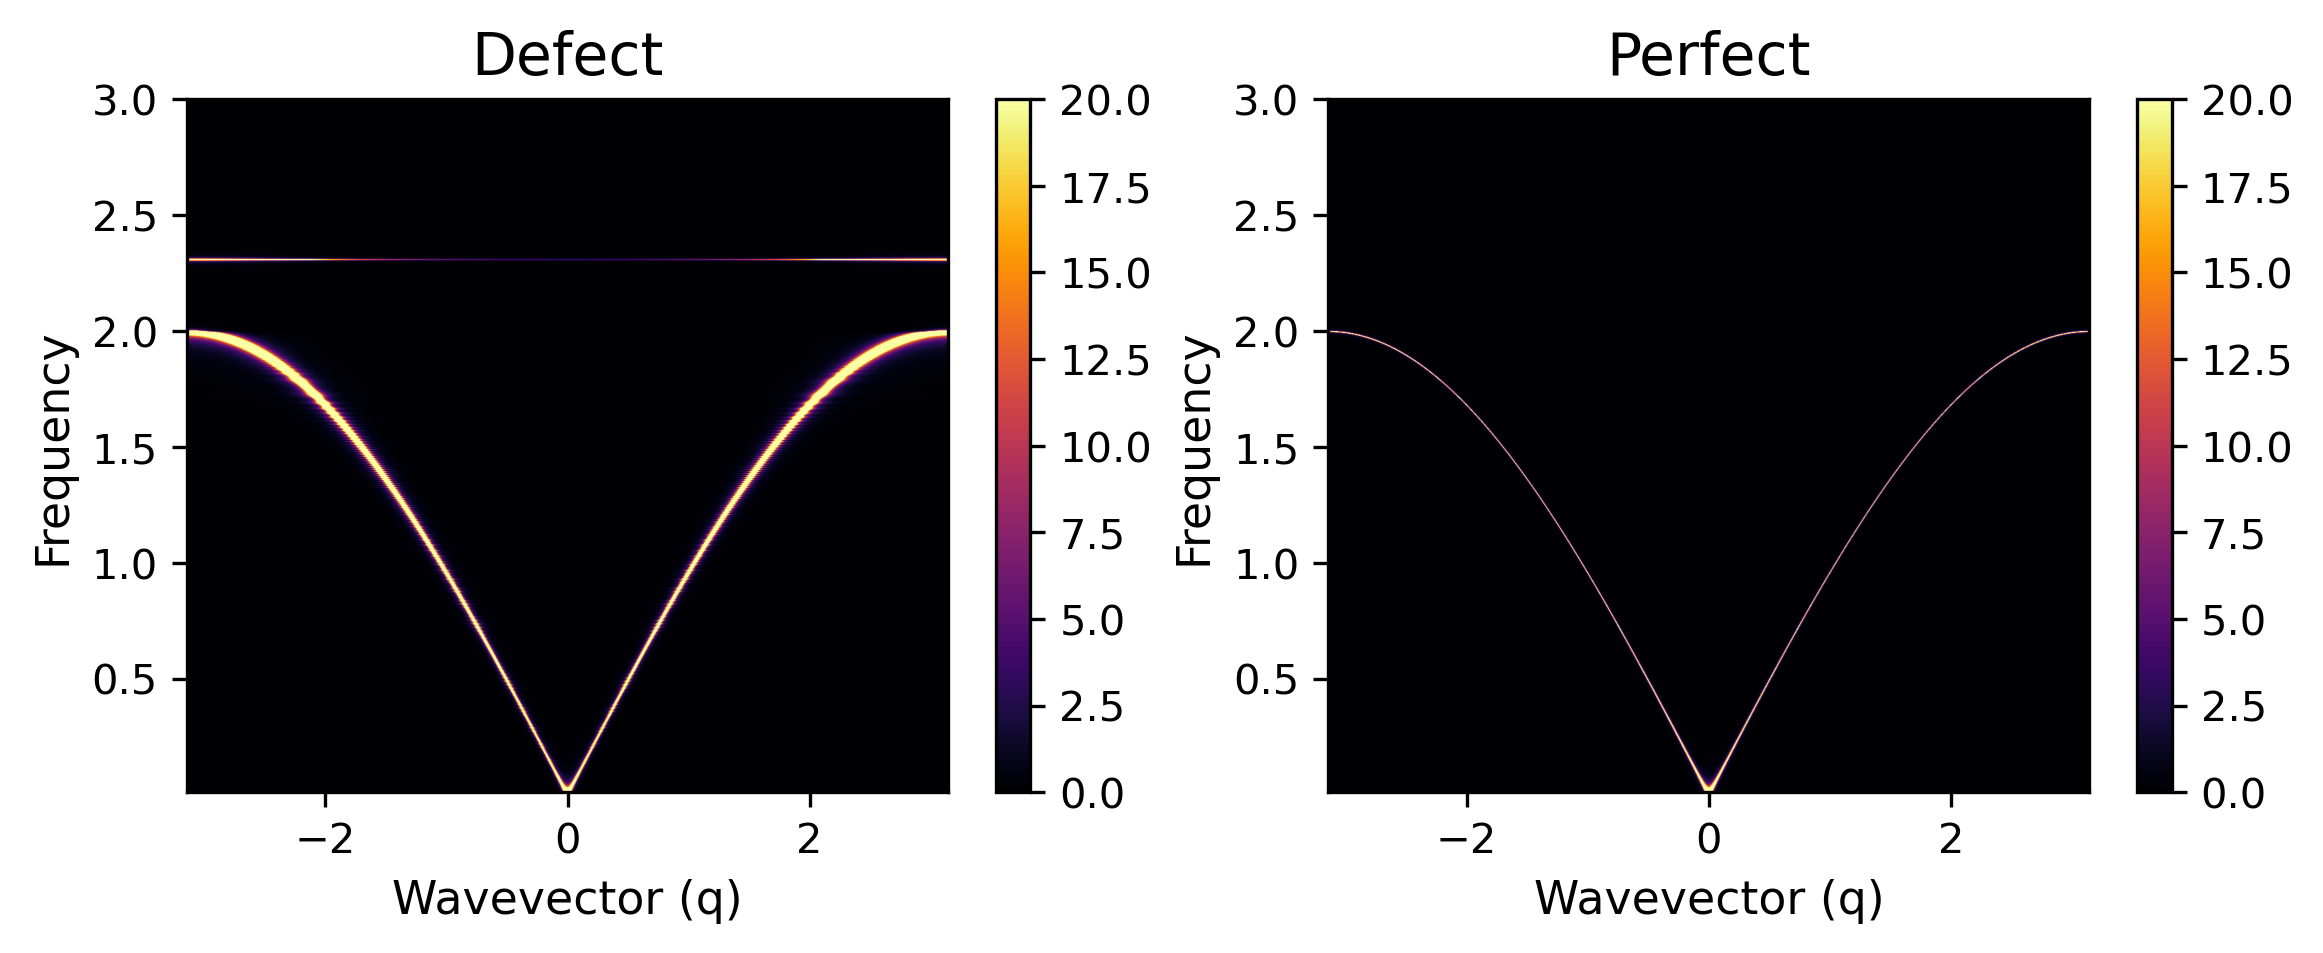

In [4]:
fig = figure(figsize=(9, 3), dpi=300)
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])

im1 = ax1.pcolormesh(q_values, omega_range, A0_grid', 
                     shading="gouraud", cmap="inferno", vmin=0, vmax=20)
#ax3.plot(q_values, frequencies, 'w--', lw=1, alpha=0.8)
ax1.set_title("Perfect", fontsize=14)
ax1.set_xlabel("Wavevector (q)", fontsize=11)
ax1.set_ylabel("Frequency", fontsize=11)
fig.colorbar(im1, ax=ax1)

im3 = ax3.pcolormesh(q_values, omega_range, A_full_grid', 
                     shading="gouraud", cmap="inferno", vmin=0, vmax=20)
#ax3.plot(q_values, frequencies, 'w--', lw=1, alpha=0.8)
ax3.set_title("Defect", fontsize=14)
ax3.set_xlabel("Wavevector (q)", fontsize=11)
ax3.set_ylabel("Frequency", fontsize=11)
fig.colorbar(im3, ax=ax3)

show()

In [13]:
pdos1=sum(A_full_grid,dims=1)
pdos2=sum(A0_grid,dims=1)

1×1000 Matrix{Float64}:
 12912.5  10505.3  9189.27  7726.36  6973.29  …  0.223746  0.222666  0.221594

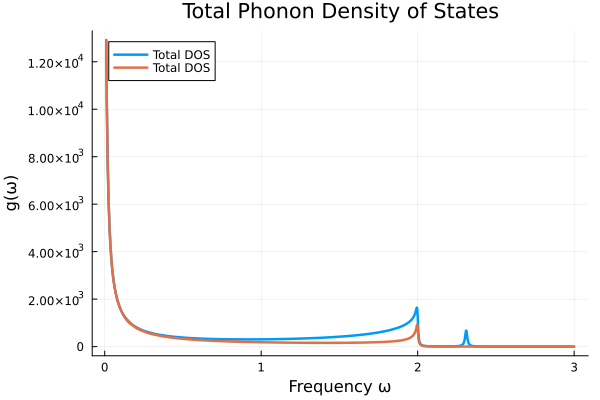

In [15]:
plot(omega_range, pdos1', # 使用转置 ' 将 1xN_w 的矩阵变为 N_wx1 的列向量以供绘图
          label="Total DOS",
          linewidth=2.5,
          title="Total Phonon Density of States",
          xlabel="Frequency ω",
          ylabel="g(ω)",
          legend=:topleft)

plot!(omega_range, pdos2', # 使用转置 ' 将 1xN_w 的矩阵变为 N_wx1 的列向量以供绘图
          label="Total DOS",
          linewidth=2.5,
          title="Total Phonon Density of States",
          xlabel="Frequency ω",
          ylabel="g(ω)",
          legend=:topleft)

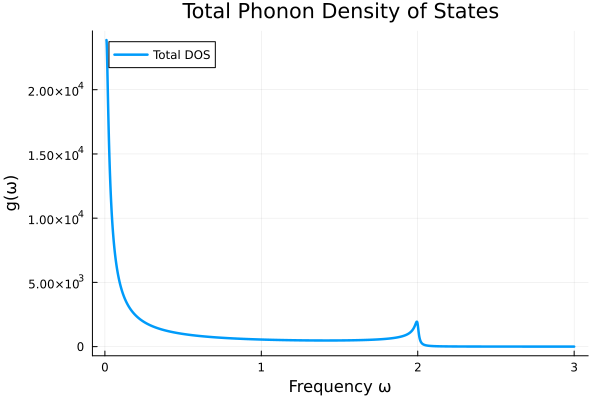

Step 1: Pre-calculating PERFECT LATTICE phonon spectrum... (running on 1 threads)
Done.
Step 2: Pre-calculating T-matrix and Green's functions for PERFECT LATTICE...
Done.
Step 3: Calculating full and difference spectral functions...
Done.
Step 4: Plotting results...


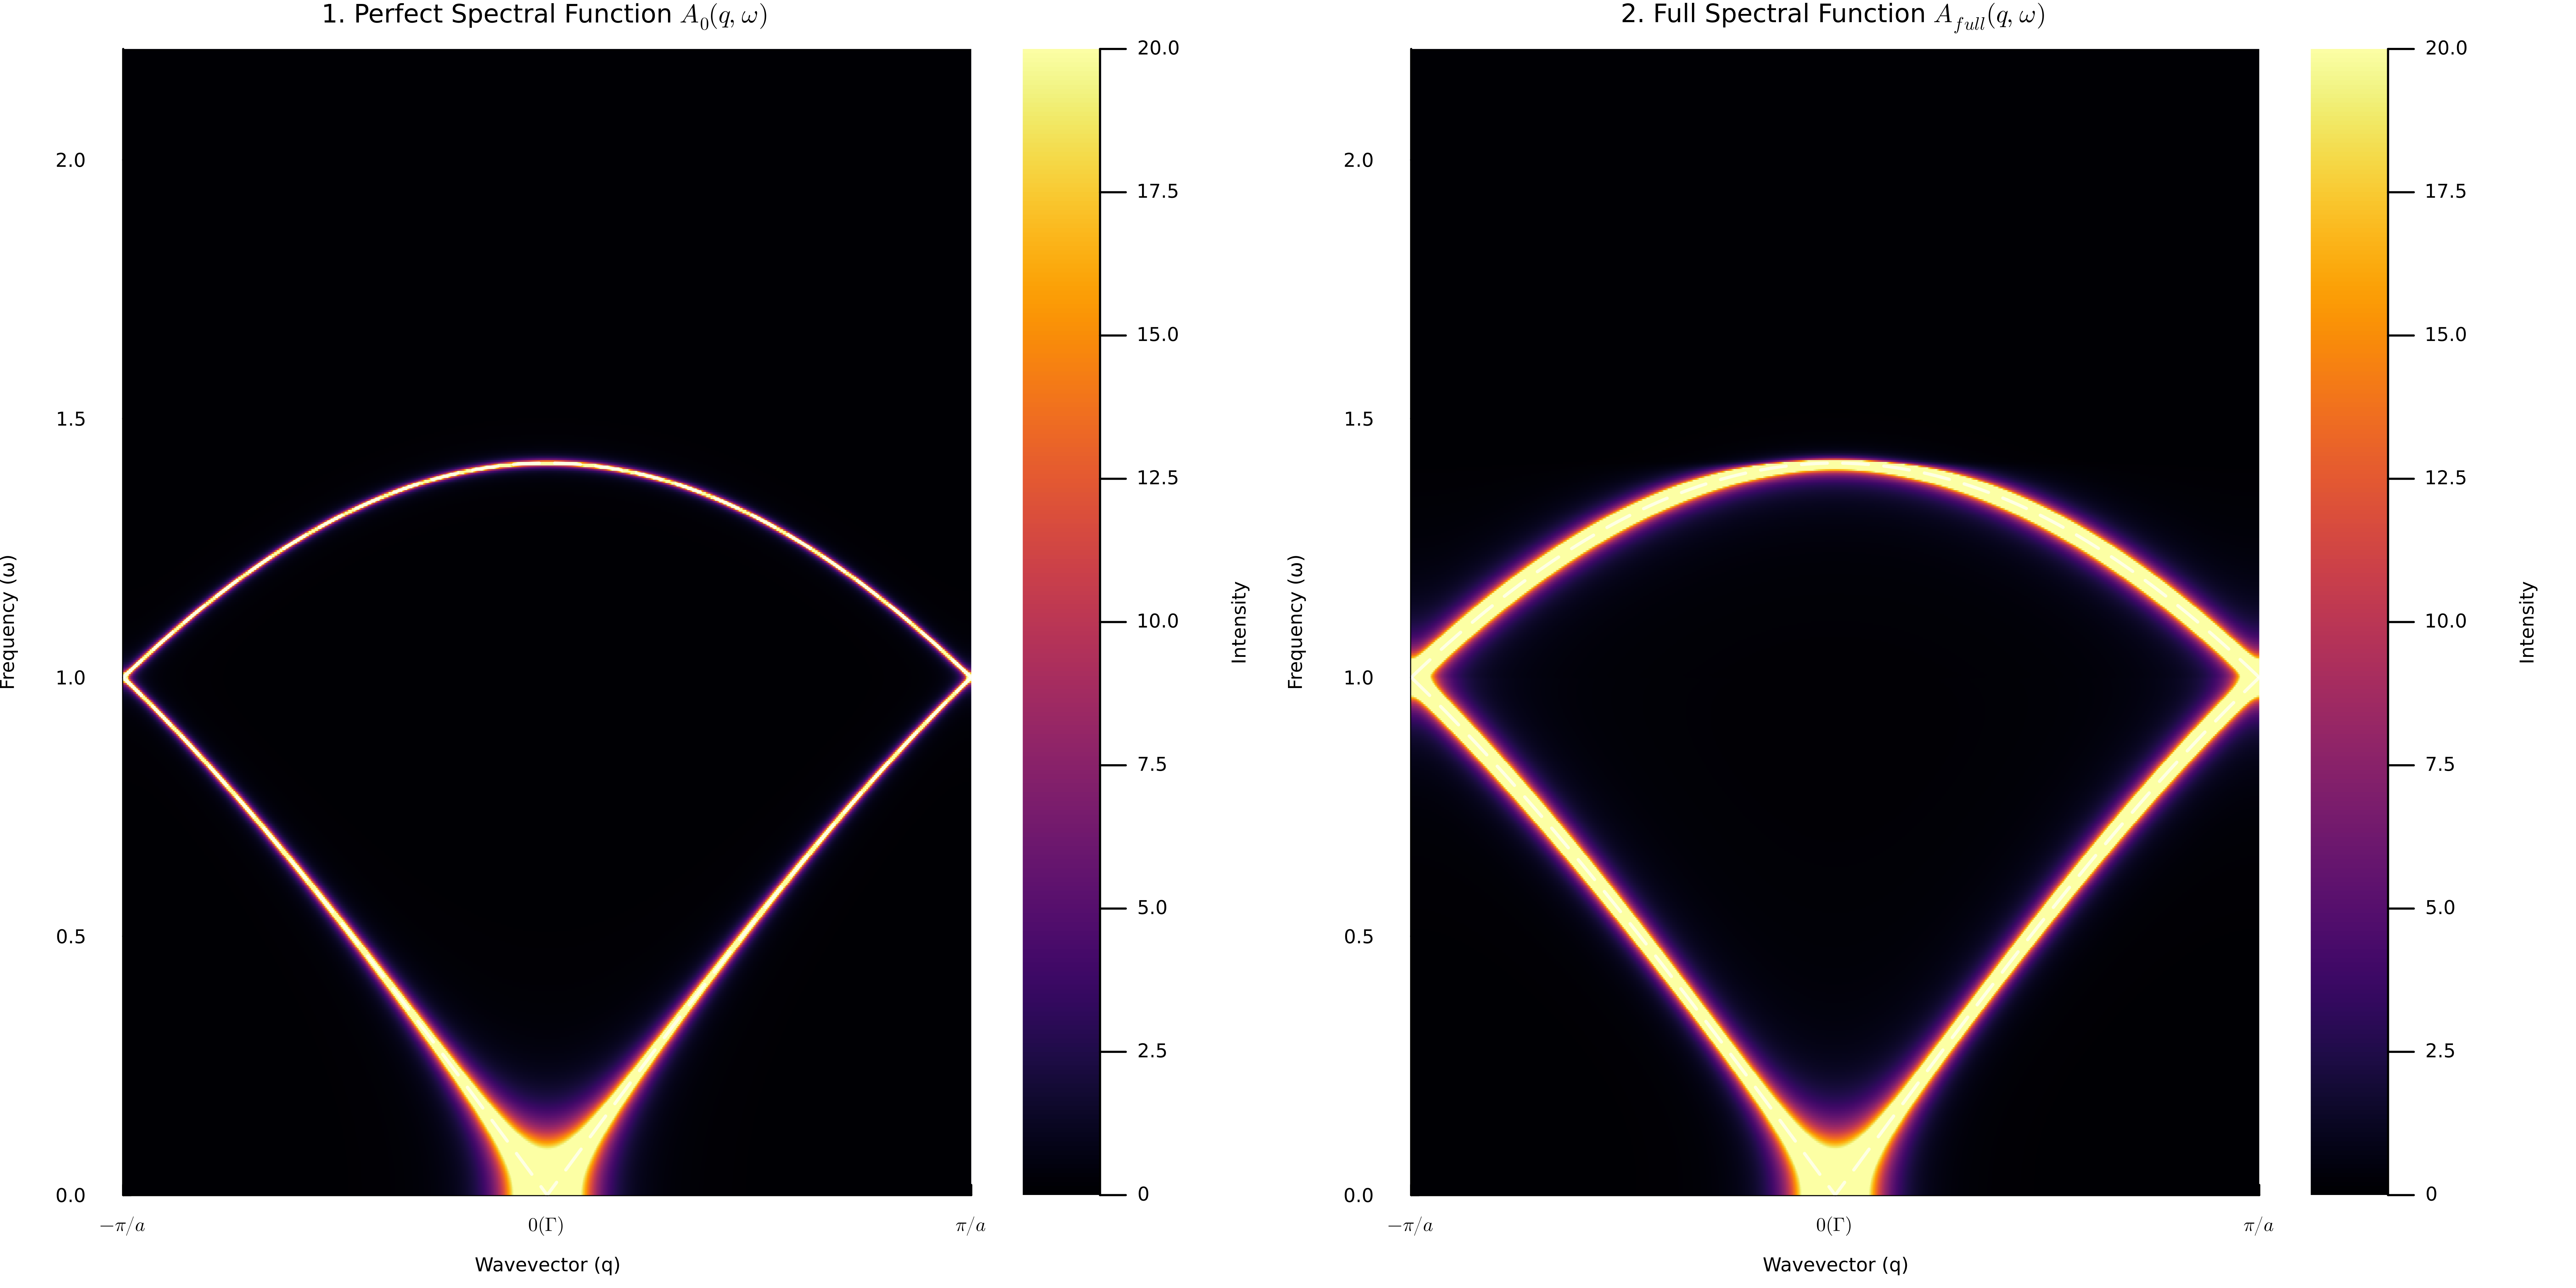


All processes finished. Current time in Austin is h:19:34 PM.


In [1]:
# =============================================================================
# Section 0: 引入模块
# =============================================================================
using Plots
using LinearAlgebra
using Statistics
using Printf
using LaTeXStrings # <-- 添加这一行以修复 L"..." 错误
using Dates        # <-- 添加这些以修复之前的时间打印错误
using TimeZones

# =============================================================================
# Section 1: 定义物理参数和计算设置
# =============================================================================
# -- 完美晶格参数 --
const m1, m2, C, a = 2.0, 2.0, 1.0, 1.0
# -- 缺陷参数 --
const m_imp = 0.8
const conc = 0.5
# -- 计算设置 --
const N_q_points = 1000
const N_omega_points = 1000
const eta = 0.01

# =============================================================================
# Section 2: 预计算完美晶格的声子谱
# =============================================================================
@printf("Step 1: Pre-calculating PERFECT LATTICE phonon spectrum... (running on %d threads)\n", Threads.nthreads())
q_values = range(-π / a, π / a, length=N_q_points)
eigenvalues_all_q = zeros(N_q_points, 2)
eigenvectors_all_q = zeros(ComplexF64, N_q_points, 2, 2)

for (i, q) in enumerate(q_values)
    d11 = 2 * C / m1
    d22 = 2 * C / m2
    d12 = -C * (1 + exp(-1im * q * a)) / sqrt(m1 * m2)
    dynamical_matrix = Hermitian([d11 d12; conj(d12) d22])
    sol = eigen(dynamical_matrix)
    eigenvalues_all_q[i, :] = sol.values
    eigenvectors_all_q[i, :, :] = sol.vectors
end

frequencies_all_q = sqrt.(max.(eigenvalues_all_q, 0))
max_freq = maximum(frequencies_all_q)
omega_range = range(0.00, max_freq + 2, length=N_omega_points)
println("Done.")

# =============================================================================
# Section 3: 预计算T矩阵和完美体系的格林函数
# =============================================================================
println("Step 2: Pre-calculating T-matrix and Green's functions for PERFECT LATTICE...")
G0_q_omega_grid = zeros(ComplexF64, N_q_points, N_omega_points, 2, 2)

for i in 1:N_q_points
    G0_q = zeros(ComplexF64, N_omega_points, 2, 2)
    for j in 1:2
        w_sq = eigenvalues_all_q[i, j]
        e_vec = eigenvectors_all_q[i, :, j]
        numerator = e_vec * e_vec'
        denominator = omega_range.^2 .- w_sq .+ 1im * eta
        G0_q .+= reshape(numerator, 1, 2, 2) ./ denominator
    end
    G0_q_omega_grid[i, :, :, :] = G0_q
end

G0_11_all_omega = vec(mean(G0_q_omega_grid[:, :, 1, 1], dims=1))
delta_m = m_imp - m1
v_defect_all_omega = delta_m .* omega_range.^2
T_matrix_all_omega = conc .* v_defect_all_omega ./ (1.0 .- G0_11_all_omega .* v_defect_all_omega)
println("Done.")

# =============================================================================
# Section 4: 计算全谱函数和差值谱函数
# =============================================================================
println("Step 3: Calculating full and difference spectral functions...")
A0_grid = [-imag(tr(G0_q_omega_grid[i, k, :, :])) / π for i in 1:N_q_points, k in 1:N_omega_points]
A_full_grid = zeros(N_q_points, N_omega_points)

Threads.@threads for i in 1:N_q_points
    for k in 1:N_omega_points
        G0_qw = G0_q_omega_grid[i, k, :, :]
        T_w = T_matrix_all_omega[k]
        g_vector = G0_qw[:, 1:1]
        delta_G = g_vector * T_w * g_vector'
        G_full_qw = G0_qw + delta_G
        A_full_grid[i, k] = -imag(tr(G_full_qw)) / π
    end
end

delta_A_grid = A_full_grid - A0_grid
println("Done.")

# =============================================================================
# Section 5: 可视化结果
# =============================================================================
println("Step 4: Plotting results...")

xtick_vals = [-π/a, 0, π/a]
xtick_labs = [L"$-\pi/a$", L"0 (Γ)", L"$\pi/a$"] # <-- 现在可以正常工作了

vmax_diff = maximum(abs.(delta_A_grid))

p1 = heatmap(q_values, omega_range, A0_grid', title=L"1. Perfect Spectral Function $A_0(q, \omega)$", c=:inferno, clim=(0, 20), colorbar_title="Intensity")
plot!(p1, q_values, frequencies_all_q, c=:white, ls=:dash, lw=1.5, alpha=0.7, label=false)

p2 = heatmap(q_values, omega_range, A_full_grid', title=L"2. Full Spectral Function $A_{full}(q, \omega)$", c=:inferno, clim=(0, 20), colorbar_title="Intensity")
plot!(p2, q_values, frequencies_all_q, c=:white, ls=:dash, lw=1.5, alpha=0.7, label=false)

p3 = heatmap(q_values, omega_range, delta_A_grid', title=L"3. Difference $\Delta A = A_{full} - A_0$", c=:bwr, clim=(-vmax_diff, vmax_diff), colorbar_title="Gain / Loss")
plot!(p3, q_values, frequencies_all_q, c=:black, ls=:dash, lw=1.5, alpha=0.4, label=false)

final_plot = plot(p1, p2,dpi=600,
    layout = (1, 2),
    size = (1200, 600),
    link = :all,
    xlabel = "Wavevector (q)",
    ylabel = "Frequency (ω)",
    xticks = (xtick_vals, xtick_labs),
    xlims = (-π/a, π/a),
    ylims = (0, max_freq + 0.8),
    left_margin = 3Plots.mm,
    bottom_margin = 3Plots.mm,
    titlefontsize = 8,        # 所有子图标题的大小
    guidefontsize = 6,        # x, y 轴标签的大小
    tickfontsize = 6,         # 坐标轴刻度数字的大小
    legendfontsize = 6,       # 图例大小 (本例中未使用图例)
    colorbar_titlefontsize = 6 # Colorbar 标题大小
)


display(final_plot)
@printf("\nAll processes finished. Current time in Austin is %s.\n", Dates.format(now(localzone()), "h:MM:SS p"))

In [2]:
pdos1=sum(A_full_grid,dims=1)
pdos2=sum(A0_grid,dims=1)

1×1000 Matrix{Float64}:
 3187.84  3189.7  3195.26  3204.47  …  0.0573109  0.0570567  0.0568038

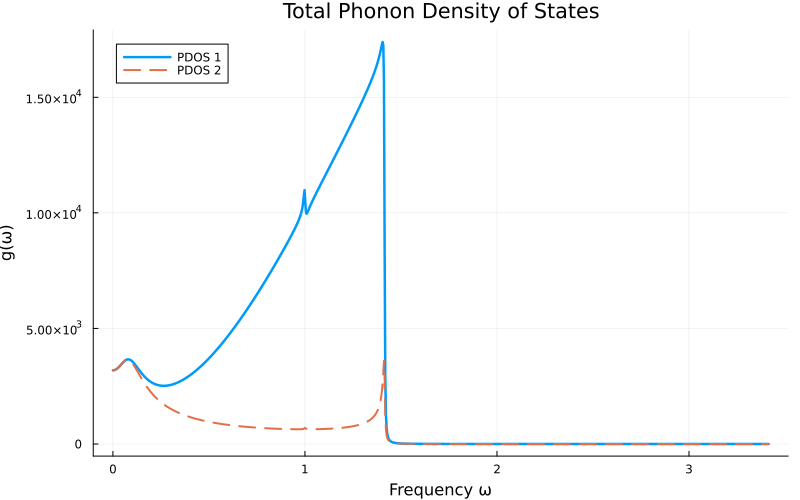

In [3]:
y_data_matrix = hcat(pdos1', pdos2') # hcat = horizontal concatenation

# 一次性绘制所有线
p_combined_alt = plot(omega_range, y_data_matrix,
    # 标签需要写成一个 1x2 的行矩阵
    label = ["PDOS 1" "PDOS 2"],
    
    # 可以为每条线分别指定线宽
    linewidth = [2.5 2.0],
    
    # 也可以分别指定线型
    linestyle = [:solid :dash],

    # --- 全局设置 ---
    title = "Total Phonon Density of States",
    xlabel = "Frequency ω",
    ylabel = "g(ω)",
    legend = :topleft,
    size = (800, 500)
)

# 显示图形
display(p_combined_alt)